In [ ]:
%%bash
# notebook dependencies
pip install s3fs
pip install xarray
pip install matplotlib
pip install zarr

In [ ]:
import s3fs
import xarray as xr   
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
RCA_s3_bucket = "ooi-data/"
fs = s3fs.S3FileSystem(anon=True)

In [4]:
ADCP_streams = [
    'CE02SHBP-LJ01D-05-ADCPTB104-streamed-adcp_velocity_beam', #oregon shelf
    'CE04OSBP-LJ01C-05-ADCPSI103-streamed-adcp_velocity_beam', #oregon offshore 
    'RS01SUM2-MJ01B-12-ADCPSK101-streamed-adcp_velocity_beam', #hydrate ridge
    'RS03AXBS-LJ03A-10-ADCPTE303-streamed-adcp_velocity_beam', #axial volcano base
    'RS01SUM2-MJ01B-12-ADCPSK101-streamed-adcp_velocity_beam', #oregon slope base
]

In [5]:
plotting_offsets = [ # (degrees) we'll offset the compass data for data viz
    20,
    16,
    12,
    8,
    4,
]

In [6]:
def load_data(stream_name):
    zarr_dir = RCA_s3_bucket + stream_name
    zarr_store = fs.get_mapper(zarr_dir)
    ds = xr.open_zarr(zarr_store, consolidated=True)
    return ds

In [7]:
# this takes a little while, ADCP streams are dense
ADCP_data_list = []
for stream in ADCP_streams:
    # ds = load_data(stream) <<< UNCOMMENT THIS IF YOU WANT TO LOAD DATA YOURSELF >>>
    print(f"loaded {stream}")
    ADCP_data_list.append(ds)

loaded CE02SHBP-LJ01D-05-ADCPTB104-streamed-adcp_velocity_beam
loaded CE04OSBP-LJ01C-05-ADCPSI103-streamed-adcp_velocity_beam
loaded RS01SUM2-MJ01B-12-ADCPSK101-streamed-adcp_velocity_beam
loaded RS03AXBS-LJ03A-10-ADCPTE303-streamed-adcp_velocity_beam
loaded RS01SUM2-MJ01B-12-ADCPSK101-streamed-adcp_velocity_beam


In [15]:
start_time = pd.to_datetime('2024-05-09')
end_time = pd.to_datetime('2024-05-13')

In [20]:
def get_compass_heading_in_degrees(ds, plotting_offset):
    heading = ds.heading # grab heading data array from ADCP dataset
    heading = heading.sel(time=slice(start_time, end_time))
    heading = heading - heading.mean() # center data by subtracting mean
    heading = heading / 100 # convert centidegrees to degrees
    heading = heading + plotting_offset # offset data for plot
    #heading = heading.rename(name) # human readable name
    heading = heading.coarsen(time=40, boundary='trim').mean() # lowering the resolution makes data easier to view
    
    return heading

In [21]:
aurora_data = []
for i, ds in enumerate(ADCP_data_list):
    aurora_da = get_compass_heading_in_degrees(ADCP_data_list[i], plotting_offsets[i])
    aurora_data.append(aurora_da)

Text(0, 0.5, 'Degrees')

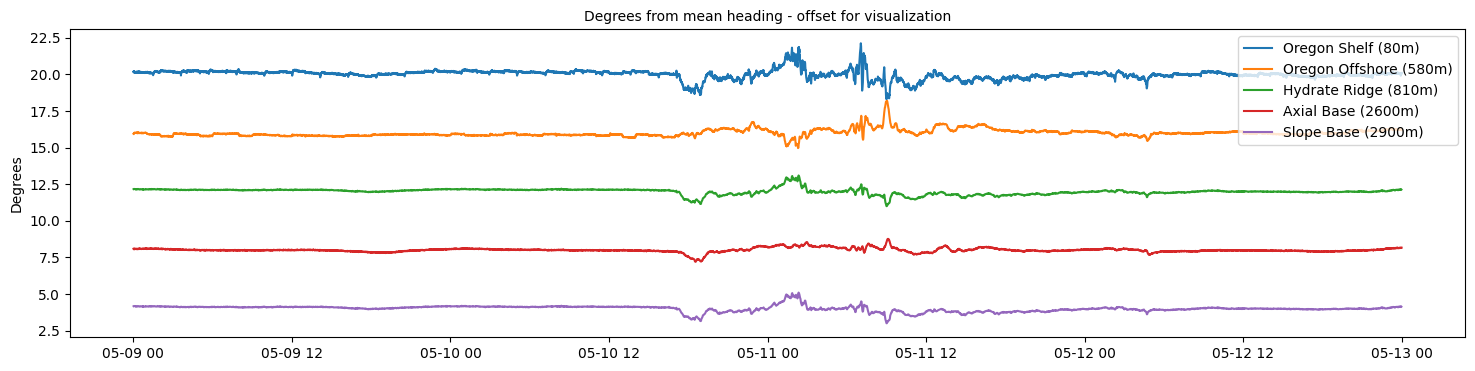

In [22]:
fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(aurora_data[0].time, aurora_data[0], label='Oregon Shelf (80m)')
ax.plot(aurora_data[1].time, aurora_data[1], label='Oregon Offshore (580m)')
ax.plot(aurora_data[2].time, aurora_data[2], label='Hydrate Ridge (810m)') 
ax.plot(aurora_data[3].time, aurora_data[3], label='Axial Base (2600m)') 
ax.plot(aurora_data[4].time, aurora_data[4], label='Slope Base (2900m)') 

ax.legend(loc='upper right', markerscale=4)
ax.set_title('Degrees from mean heading - offset for visualization', fontsize=10)
ax.set_ylabel('Degrees')